In [4]:
# Project paths (booking pipeline)
from pathlib import Path
import sys

def find_repo_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / "pyproject.toml").exists() and (p / "src" / "airline_revenue_analytics").exists():
            return p
    return start

REPO_ROOT = find_repo_root(Path.cwd())
PROJECT_ROOT = REPO_ROOT
SRC_ROOT = REPO_ROOT / "src"
if str(SRC_ROOT) not in sys.path:
    sys.path.append(str(SRC_ROOT))

from airline_revenue_analytics.config import get_paths

PATHS = get_paths("booking")
DATA_DIR = REPO_ROOT / "data"
RAW_DIR = PATHS.data_raw
DB_PATH = PATHS.db_path
OUTPUT_DIR = PATHS.outputs_root
FIG_DIR = PATHS.figures
TAB_DIR = PATHS.tables
ART_DIR = PATHS.artifacts

def _rel(p: Path) -> str:
    try:
        return str(Path(p).resolve().relative_to(REPO_ROOT))
    except Exception:
        return Path(p).name

print("REPO_ROOT:", REPO_ROOT.name)
print("DB_PATH:", _rel(DB_PATH))
print("OUTPUT_DIR:", _rel(OUTPUT_DIR))


REPO_ROOT: airline-revenue-analytics
DB_PATH: data/raw/airlines_db.sqlite
OUTPUT_DIR: outputs/booking


 
# 03 - Transformation & Split (Steps 4.1–4.3)
Goal: create a clean modeling matrix, run feature-scoring (MI/VIF), and
prepare a reproducible train/test split with preprocessing artifacts.
Outputs:
- `outputs/booking/artifacts/preprocessor.joblib`
- `outputs/booking/tables/table_4_3_1_train_test_counts.csv`
- `outputs/booking/tables/table_4_3_2_feature_names_after_ohe.csv`
- `outputs/booking/tables/table_4_1_1_mi.csv`  + `outputs/booking/figures/figure_4_1_1_mi.png`
- `outputs/booking/tables/table_4_1_1_vif.csv` + `outputs/booking/figures/figure_4_1_1_vif.png`
- `outputs/booking/tables/table_4_1_2_importances.csv`
  + `outputs/booking/figures/figure_4_1_2_impurity.png`
  + `outputs/booking/figures/figure_4_1_2_permutation.png`
  + `outputs/booking/figures/figure_4_1_2_random_forest_both.png`


In [5]:
# Imports & paths
import sys, pathlib, numpy as np, pandas as pd
import matplotlib; import matplotlib.pyplot as plt

# Make sure "src" is importable when running from notebooks/
sys.path.append(str(PROJECT_ROOT))


from airline_revenue_analytics.features.segment import to_utc  # (not strictly needed here but available)
# We'll build preprocessing here; modeling will be in the next notebook as well.

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import joblib

# Dirs
OUT_DIR = OUTPUT_DIR
FIG_DIR = OUT_DIR / "figures"
TAB_DIR = OUT_DIR / "tables"
ART_DIR = OUT_DIR / "artifacts"

SEED = 42
np.random.seed(SEED)

print("FIG_DIR:", _rel(FIG_DIR))
print("TAB_DIR:", _rel(TAB_DIR))
print("ART_DIR:", _rel(ART_DIR))


FIG_DIR: outputs/booking/figures
TAB_DIR: outputs/booking/tables
ART_DIR: outputs/booking/artifacts


In [6]:
from airline_revenue_analytics.viz.charts import apply_style, PLOT_COLORS
apply_style()
PASS_COLOR = "#D9F2E6"
FAIL_COLOR = "#FCE4E4"
NEG_BG_COLOR = FAIL_COLOR


In [7]:
# Load booking-level dataset built in 02
df = pd.read_parquet(TAB_DIR / "booking_model_df.parquet")
print(df.shape)
df.head(3)


(170227, 13)


,book_ref,n_segments,sum_sched_duration_min,avg_sched_duration_min,max_sched_duration_min,share_premium_cabin,max_cabin_index,has_longhaul,n_unique_routes,primary_route_code,avg_booking_lead_days,total_amount,log_total_amount
0,00000F,2,1050.0,525.0,525.0,0.500,2,1,2,SVO-UUS,15.450000,265700,12.490123
1,000012,2,210.0,105.0,105.0,0.500,1,0,2,AER-SVO,20.359722,37900,10.542706
2,0002E0,8,660.0,82.5,135.0,0.125,2,0,4,MCX-MRV,16.613542,89600,11.403111


In [8]:
# Define target and features (numeric + one categorical)
target = "log_total_amount"

# Numeric features (schedule-based, leakage-safe)
num_cols = [
    "n_segments", "sum_sched_duration_min", "avg_sched_duration_min",
    "max_sched_duration_min", "share_premium_cabin", "max_cabin_index",
    "has_longhaul", "n_unique_routes", "avg_booking_lead_days"
]

# Create a fixed split BEFORE train-derived feature engineering
idx_train, idx_test = train_test_split(
    df.index, test_size=0.30, random_state=SEED, shuffle=True
)

# Categorical feature (limit cardinality for stability; train-only top-K)
cat_raw = df["primary_route_code"].astype("string").fillna("Unknown")
top_k = 20
top_routes = cat_raw.loc[idx_train].value_counts().index[:top_k].tolist()
df["primary_route_code_top"] = np.where(cat_raw.isin(top_routes), cat_raw, "Other")
cat_cols = ["primary_route_code_top"]

X_all = df[num_cols + cat_cols].copy()
y_all = df[target].copy()
X_train = X_all.loc[idx_train]

# Preprocessor: impute+scale for numeric, impute+OHE for categorical
pre = ColumnTransformer([
    ("num", Pipeline([("imputer", SimpleImputer(strategy="median")),
                      ("scaler", StandardScaler())]), num_cols),
    ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                      ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]), cat_cols),
])

# Fit on train split only to avoid leakage
pre.fit(X_train)
X_all_trans = pre.transform(X_all)

# Compose final feature names
ohe = pre.named_transformers_["cat"].named_steps["ohe"]
feat_names = num_cols + list(ohe.get_feature_names_out(cat_cols))

# Persist artifacts & feature names
joblib.dump(pre, ART_DIR/"preprocessor.joblib")
pd.DataFrame({"feature": feat_names}).to_csv(TAB_DIR/"table_4_3_2_feature_names_after_ohe.csv", index=False)

len(feat_names), feat_names[:8]


(30,
 ['n_segments',
  'sum_sched_duration_min',
  'avg_sched_duration_min',
  'max_sched_duration_min',
  'share_premium_cabin',
  'max_cabin_index',
  'has_longhaul',
  'n_unique_routes'])

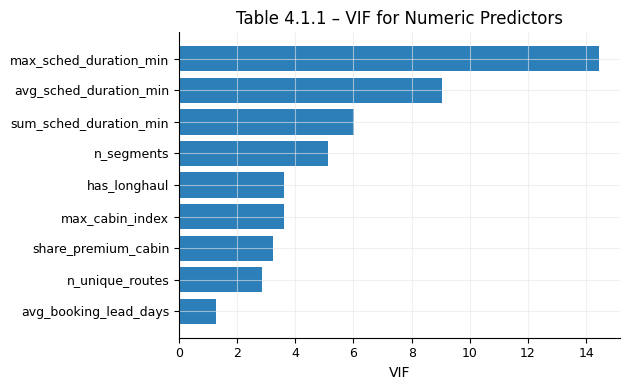

,feature,VIF
3,max_sched_duration_min,14.442801
2,avg_sched_duration_min,9.027795
1,sum_sched_duration_min,6.014322
0,n_segments,5.139456
6,has_longhaul,3.625932
5,max_cabin_index,3.618651
4,share_premium_cabin,3.223194
7,n_unique_routes,2.851996
8,avg_booking_lead_days,1.270781


In [9]:
# VIF on numeric features only (after median-impute + standardize)
Xn = df[num_cols].copy()
for c in num_cols:
    Xn[c] = pd.to_numeric(Xn[c], errors="coerce")
Xn = Xn.fillna(Xn.median(numeric_only=True))
scaler = StandardScaler()
Xn_scaled = scaler.fit_transform(Xn)

vifs = []
for i, col in enumerate(num_cols):
    vifs.append((col, float(variance_inflation_factor(Xn_scaled, i))))
vif_df = pd.DataFrame(vifs, columns=["feature","VIF"]).sort_values("VIF", ascending=False)
vif_df.to_csv(TAB_DIR/"table_4_1_1_vif.csv", index=False)

# Plot
sub = vif_df.head(20).iloc[::-1]
plt.figure()
plt.barh(sub["feature"], sub["VIF"])
plt.title("Table 4.1.1 – VIF for Numeric Predictors")
plt.xlabel("VIF")
plt.tight_layout()
plt.savefig(FIG_DIR/"figure_4_1_1_vif.png", dpi=150)
plt.show()

vif_df.head(10)


In [10]:
# 4.3 – Create reproducible train/test split and save evidence (FIXED to keep 'index' column)

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# 使用与前面一致的 X_all / y_all / df（来自本笔记本较早的单元）
# Ensure we reuse the same split used for train-only top-K routes
try:
    idx_train
    idx_test
except NameError:
    idx_train, idx_test = train_test_split(
        df.index, test_size=0.30, random_state=SEED, shuffle=True
    )

X_train, X_test = X_all.loc[idx_train], X_all.loc[idx_test]
y_train, y_test = y_all.loc[idx_train], y_all.loc[idx_test]

# 保存切分计数（证据）
pd.DataFrame(
    {"split": ["train", "test"], "rows": [len(X_train), len(X_test)]}
).to_csv(TAB_DIR / "table_4_3_1_train_test_counts.csv", index=False)

# 保存切分成员（**保留 index 列**，并附上 book_ref 便于人读）
split_ids = pd.DataFrame({
    "index": list(idx_train) + list(idx_test),
    "split": ["train"] * len(idx_train) + ["test"] * len(idx_test)
})
split_ids["book_ref"] = df.loc[split_ids["index"], "book_ref"].values

split_ids.to_csv(TAB_DIR / "table_4_3_1_split_ids.csv", index=False)

# 返回形状，便于快速检查
(len(X_train), len(X_test))


(119158, 51069)

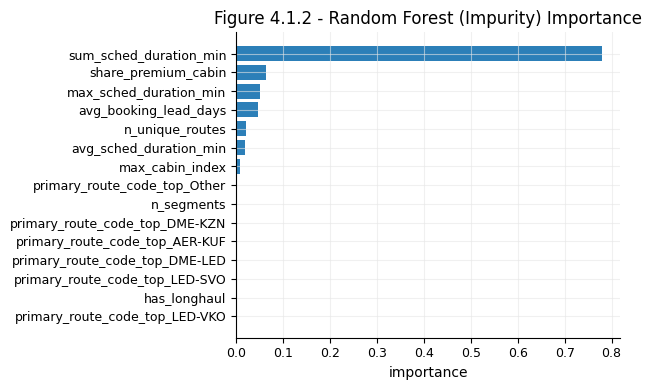

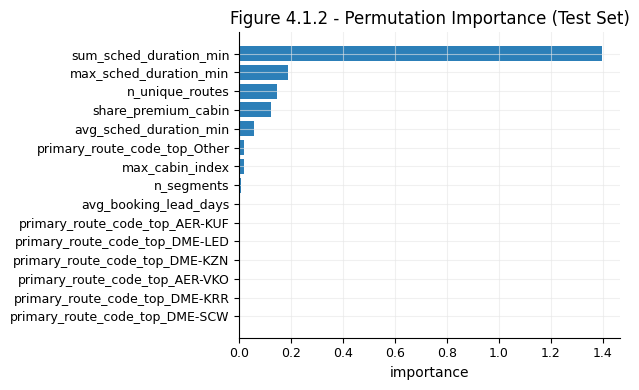

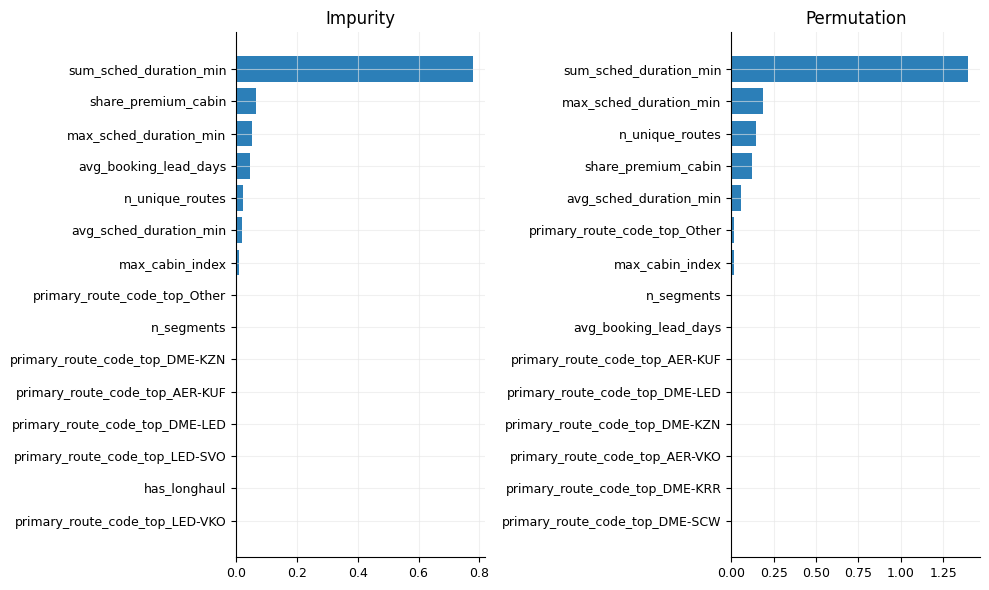

,feature,impurity_importance,permutation_importance
0,avg_booking_lead_days,0.047250,0.001939
1,avg_sched_duration_min,0.018970,0.056759
2,has_longhaul,0.000326,0.000116
3,max_cabin_index,0.007936,0.017029
4,max_sched_duration_min,0.051371,0.187648
5,n_segments,0.001898,0.005687
6,n_unique_routes,0.021569,0.146853
7,primary_route_code_top_AAQ-SVO,0.000077,0.000045
8,primary_route_code_top_AER-KUF,0.000948,0.001415
9,primary_route_code_top_AER-SVO,0.000163,0.000065


In [11]:
# 4.1.2 - Random Forest importance (impurity + permutation on transformed matrix)

from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline

rf = RandomForestRegressor(
    n_estimators=500,
    random_state=SEED,
    n_jobs=-1,
    max_depth=None,
    min_samples_leaf=2
)
pipe = Pipeline([("pre", pre), ("model", rf)])
pipe.fit(X_train, y_train)

# Feature names after fitting on TRAIN (OHE categories come from train only)
ohe_train = pipe.named_steps["pre"].named_transformers_["cat"].named_steps["ohe"]
feat_names_train = num_cols + list(ohe_train.get_feature_names_out(cat_cols))

# (A) Impurity-based importance
imp = pipe.named_steps["model"].feature_importances_
imp_df = (
    pd.DataFrame({"feature": feat_names_train, "impurity_importance": imp})
      .sort_values("impurity_importance", ascending=False)
)

# (B) Permutation importance on the TRANSFORMED test matrix
# Transform X_test with the train-fitted preprocessor INSIDE the pipeline
X_test_trans = pipe.named_steps["pre"].transform(X_test)

perm = permutation_importance(
    pipe.named_steps["model"],   # evaluate the fitted model only
    X_test_trans,                # use transformed features (same dimensionality as feat_names_train)
    y_test,
    n_repeats=10,
    random_state=SEED,
    n_jobs=1                     # set to 1 to avoid macOS multiprocessing warnings
)

perm_df = (
    pd.DataFrame({
        "feature": feat_names_train,
        "permutation_importance": perm.importances_mean
    })
    .sort_values("permutation_importance", ascending=False)
)

# Merge and save
imp_merge = pd.merge(imp_df, perm_df, on="feature", how="outer").fillna(0.0)
imp_merge.sort_values("impurity_importance", ascending=False).to_csv(
    TAB_DIR/"table_4_1_2_importances.csv", index=False
)

# Plot: Impurity (top 15)
sub = imp_df.head(15).iloc[::-1]
plt.figure()
plt.barh(sub["feature"], sub["impurity_importance"])
plt.title("Figure 4.1.2 - Random Forest (Impurity) Importance")
plt.xlabel("importance")
plt.tight_layout()
plt.savefig(FIG_DIR/"figure_4_1_2_impurity.png", dpi=150)
plt.show()

# Plot: Permutation (top 15)
subp = perm_df.head(15).iloc[::-1]
plt.figure()
plt.barh(subp["feature"], subp["permutation_importance"])
plt.title("Figure 4.1.2 - Permutation Importance (Test Set)")
plt.xlabel("importance")
plt.tight_layout()
plt.savefig(FIG_DIR/"figure_4_1_2_permutation.png", dpi=150)
plt.show()

# Combined figure (optional)
plt.figure(figsize=(10,6))
plt.subplot(1,2,1); plt.barh(sub["feature"], sub["impurity_importance"]); plt.title("Impurity")
plt.subplot(1,2,2); plt.barh(subp["feature"], subp["permutation_importance"]); plt.title("Permutation")
plt.tight_layout(); plt.savefig(FIG_DIR/"figure_4_1_2_random_forest_both.png", dpi=150); plt.show()

imp_merge.head(10)


 
**Summary (Step 4):**
- Preprocessor (impute/scale/OHE) has been fitted and saved to `outputs/booking/artifacts/preprocessor.joblib`.
- MI, VIF and RF-based importances highlight key drivers for modeling.
- Train/test split (70/30, random_state=42) is saved for evidence.

**Next:** open `04_modeling_loopA.ipynb` (Steps 5–7, Loop A – baseline models: Linear vs Tree),
then `05_modeling_loopB.ipynb` (Loop B – stronger models & feature tweaks), and finally
`06_interpretation_compare.ipynb` (Step 8).


In [12]:
# ---- 4.3 (final): stratified 70/30 split on log_total_amount deciles, random_state=42 ----
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

assert "total_amount" in df.columns, "booking_model_df must contain total_amount"
y_log = df["log_total_amount"] if "log_total_amount" in df.columns else np.log(df["total_amount"])

# Decile bins for stratification (handles ties safely)
strata = pd.qcut(y_log, q=10, labels=False, duplicates="drop")

feature_cols = [c for c in df.columns if c not in ("total_amount", "log_total_amount")]
X = df[feature_cols].copy()

X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.30, random_state=42, shuffle=True, stratify=strata
)

# Train-only top-K for route mapping (avoid leakage)
if "primary_route_code" in df.columns:
    cat_raw = df["primary_route_code"].astype("string").fillna("Unknown")
    top_k = 20
    top_routes = cat_raw.loc[X_train.index].value_counts().index[:top_k].tolist()
    df["primary_route_code_top"] = np.where(cat_raw.isin(top_routes), cat_raw, "Other")

# Persist split membership for reproducibility
split_ids = pd.DataFrame({
    "book_ref": df["book_ref"] if "book_ref" in df.columns else X.index,
    "is_train": X.index.isin(X_train.index).astype(int)
})
TAB_DIR.mkdir(parents=True, exist_ok=True)
split_ids.to_csv(TAB_DIR/"split_ids.csv", index=False)

len(X_train), len(X_test)


(119158, 51069)